In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


#Loading the dataset
dataset = pd.read_csv("emotion.data")

In [2]:
dataset.head()

,Unnamed: 0,text,emotions
0,27383,i feel awful about it too because it s my job ...,sadness
1,110083,im alone i feel awful,sadness
2,140764,ive probably mentioned this before but i reall...,joy
3,100071,i was feeling a little low few days back,sadness
4,2837,i beleive that i am much more sensitive to oth...,love


In [3]:
dataset.shape

(416809, 3)

In [4]:
dataset.emotions.value_counts() 

joy         141067
sadness     121187
anger        57317
fear         47712
love         34554
surprise     14972
Name: emotions, dtype: int64

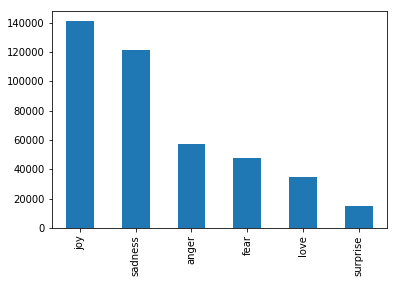

In [5]:
dataset.emotions.value_counts().plot.bar()

In [0]:
#Preparing data for model training

#Tokenization

#Since the data is already tokenized and lowercased, we just need to split the words

input_sentences = [text.split(" ") for text in dataset["text"].values.tolist()]
labels = dataset["emotions"].values.tolist()

In [7]:
#Creating Vocabulary (word index)

# Initialize word2id and label2id dictionaries that will be used to encode words and labels
word2id = dict()
label2id = dict()

max_words = 0 # maximum number of words in a sentence

# Construction of word2id dict
for sentence in input_sentences:
    for word in sentence:
        # Add words to word2id dict if not exist
        if word not in word2id:
            word2id[word] = len(word2id)
    # If length of the sentence is greater than max_words, update max_words
    if len(sentence) > max_words:
        max_words = len(sentence)
    
# Construction of label2id and id2label dicts
label2id = {l: i for i, l in enumerate(set(labels))}
id2label = {v: k for k, v in label2id.items()}
id2label

{0: 'sadness', 1: 'love', 2: 'anger', 3: 'surprise', 4: 'fear', 5: 'joy'}

In [8]:
#Encoding samples with corresponing integer values

import keras

# Encode input words and labels
X = [[word2id[word] for word in sentence] for sentence in input_sentences]
Y = [label2id[label] for label in labels]

# Apply Padding to X
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X, max_words)

# Convert Y to numpy array
Y = keras.utils.to_categorical(Y, num_classes=len(label2id), dtype='float32')

# Print shapes
print("Shape of X: {}".format(X.shape))
print("Shape of Y: {}".format(Y.shape))

Using TensorFlow backend.


Shape of X: (416809, 178)
Shape of Y: (416809, 6)


In [9]:
#Build LSTM model with attention
embedding_dim = 100 # The dimension of word embeddings

# Define input tensor
sequence_input = keras.Input(shape=(max_words,), dtype='int32')

# Word embedding layer
embedded_inputs =keras.layers.Embedding(len(word2id) + 1,
                                        embedding_dim,
                                        input_length=max_words)(sequence_input)

# Apply dropout to prevent overfitting
embedded_inputs = keras.layers.Dropout(0.2)(embedded_inputs)

# Apply Bidirectional LSTM over embedded inputs
lstm_outs = keras.layers.wrappers.Bidirectional(
    keras.layers.LSTM(embedding_dim, return_sequences=True)
)(embedded_inputs)

# Apply dropout to LSTM outputs to prevent overfitting
lstm_outs = keras.layers.Dropout(0.2)(lstm_outs)

# Attention Mechanism - Generate attention vectors
input_dim = int(lstm_outs.shape[2])
permuted_inputs = keras.layers.Permute((2, 1))(lstm_outs)
attention_vector = keras.layers.TimeDistributed(keras.layers.Dense(1))(lstm_outs)
attention_vector = keras.layers.Reshape((max_words,))(attention_vector)
attention_vector = keras.layers.Activation('softmax', name='attention_vec')(attention_vector)
attention_output = keras.layers.Dot(axes=1)([lstm_outs, attention_vector])

# Last layer: fully connected with softmax activation
fc = keras.layers.Dense(embedding_dim, activation='relu')(attention_output)
output = keras.layers.Dense(len(label2id), activation='softmax')(fc)

# Finally building model
model = keras.Model(inputs=[sequence_input], outputs=output)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')

# Print model summary
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 178)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 178, 100)     7530300     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 178, 100)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 178, 200)     160800      dropo

In [11]:
#Training the model

# Train model 10 iterations
model.fit(X, Y, epochs=1, batch_size=64, validation_split=0.1, shuffle=True)

Train on 375128 samples, validate on 41681 samples
Epoch 1/1
375128/375128 [==============================] - 4636s 12ms/step - loss: 0.0973 - acc: 0.9402 - val_loss: 0.0913 - val_acc: 0.9406


The performance can be further improved by training the model a few more iteration.

Let's look closer to model predictions and attentions

In [0]:
# Re-create the model to get attention vectors as well as label prediction
model_with_attentions = keras.Model(inputs=model.input,
                                    outputs=[model.output, 
                                             model.get_layer('attention_vec').output])

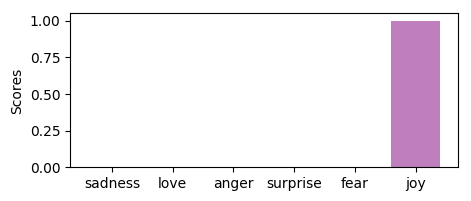

In [15]:
import random
import math

# Select random samples to illustrate
sample_text = random.choice(dataset["text"].values.tolist())

# Encode samples
tokenized_sample = sample_text.split(" ")
encoded_samples = [[word2id[word] for word in tokenized_sample]]

# Padding
encoded_samples = keras.preprocessing.sequence.pad_sequences(encoded_samples, maxlen=max_words)

# Make predictions
label_probs, attentions = model_with_attentions.predict(encoded_samples)
label_probs = {id2label[_id]: prob for (label, _id), prob in zip(label2id.items(),label_probs[0])}

# Get word attentions using attenion vector
token_attention_dic = {}
max_score = 0.0
min_score = 0.0
for token, attention_score in zip(tokenized_sample, attentions[0][-len(tokenized_sample):]):
    token_attention_dic[token] = math.sqrt(attention_score)


# VISUALIZATION
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb
    
def attention2color(attention_score):
    r = 255 - int(attention_score * 255)
    color = rgb_to_hex((255, r, r))
    return str(color)
    
# Build HTML String to viualize attentions
html_text = "<hr><p style='font-size: large'><b>Text:  </b>"
for token, attention in token_attention_dic.items():
    html_text += "<span style='background-color:{};'>{} <span> ".format(attention2color(attention),
                                                                        token)
html_text += "</p>"
# Display text enriched with attention scores 
display(HTML(html_text))

# PLOT EMOTION SCORES
emotions = [label for label, _ in label_probs.items()]
scores = [score for _, score in label_probs.items()]
plt.figure(figsize=(5,2))
plt.bar(np.arange(len(emotions)), scores, align='center', alpha=0.5, color=['black', 'red', 'green', 'blue', 'cyan', "purple"])
plt.xticks(np.arange(len(emotions)), emotions)
plt.ylabel('Scores')
plt.show()

We have used an attention mechanism with an LSTM network to recognize emotions in given text. We show that attention mechanism can be useful for classification tasks as well as sequence labeling tasks. We have illustrated the attentions in order to make model predictions interpretable and look fancy. Enjoy attentions mechanism in different applications...